In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob

读取图像

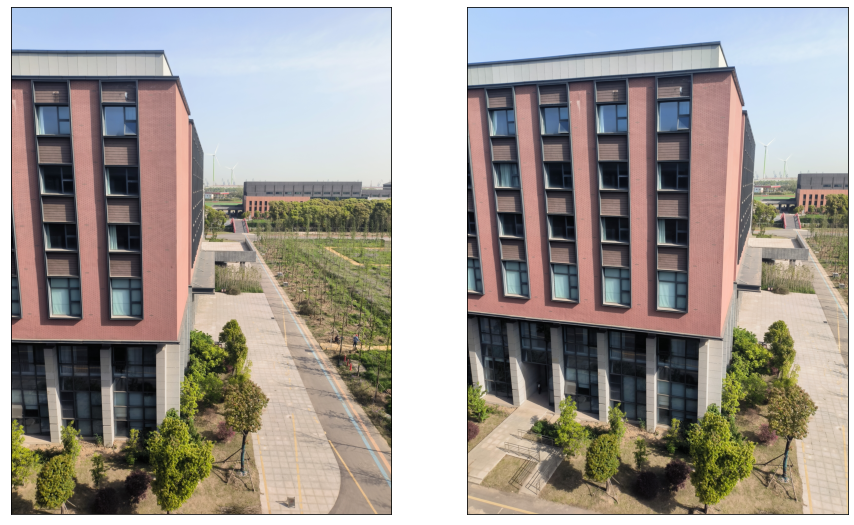

In [2]:
#加载需要拼接的图片
img_path = 'photos'
img_list = glob(os.path.join(img_path, '*.jpg'))
img1, img2 = img_list[1], img_list[0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
img1 = plt.imread(img1)
img2 = plt.imread(img2)

axes[0].imshow(img1)
axes[1].imshow(img2)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
# img1 = cv2.imread(img1)
# img2 = cv2.imread(img2)
#图片尺寸较大，进行缩放
# img1 = cv2.resize(img1, None, fx=0.25, fy=0.25)
# img2 = cv2.resize(img2, None, fx=0.25, fy=0.25)

In [3]:

#构造sift对象，计算图片的局部特征
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)#关键点及特征
kp2, des2 = sift.detectAndCompute(img2, None)
kp1 = np.array([kp.pt for kp in kp1])
kp2 = np.array([kp.pt for kp in kp2])

In [4]:
ratio=0.75
reprojThresh = 10.0
matcher = cv2.BFMatcher()
# 使用KNN检测来自A、B图的SIFT特征匹配对，K=2
rawMatches = matcher.knnMatch(des1, des2, 2)
matches = []
for m in rawMatches:
    # 当最近距离跟次近距离的比值小于ratio值时，保留此匹配对
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
    # 存储两个点在featuresA, featuresB中的索引值
        matches.append((m[0].trainIdx, m[0].queryIdx))
    # 当筛选后的匹配对大于4时，计算视角变换矩阵
# if len(matches) > 4:
#     # 获取匹配对的点坐标
#     ptsA = np.float32([kp1[i] for (_, i) in matches])
#     ptsB = np.float32([kp2[i] for (i, _) in matches])
#     # 计算视角变换矩阵
#     (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
def compute_homography(pts_src, pts_dst):
        # 构造线性方程组
        # pts_src = normalize_points(pts_src)
        # pts_dst = normalize_points(pts_dst)
        n = pts_src.shape[0]
        A = np.zeros((2*n, 9))
        for i in range(n):
            x, y = pts_src[i]
            x_, y_ = pts_dst[i]
            A[2*i] = [-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_]
            A[2*i+1] = [0, 0, 0, -x, -y, -1, x*y_, y*y_, y_]
        # 使用 SVD 分解求解方程组
        U, S, Vt = np.linalg.svd(A)
        H = Vt[-1].reshape(3, 3)
        return H / H[2, 2]
ptsA = np.float32([kp1[i] for (_, i) in matches])
ptsB = np.float32([kp2[i] for (i, _) in matches])
H = compute_homography(ptsA, ptsB)

In [8]:
result = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
# result[0:img2.shape[0], 0:img2.shape[1]] = img2

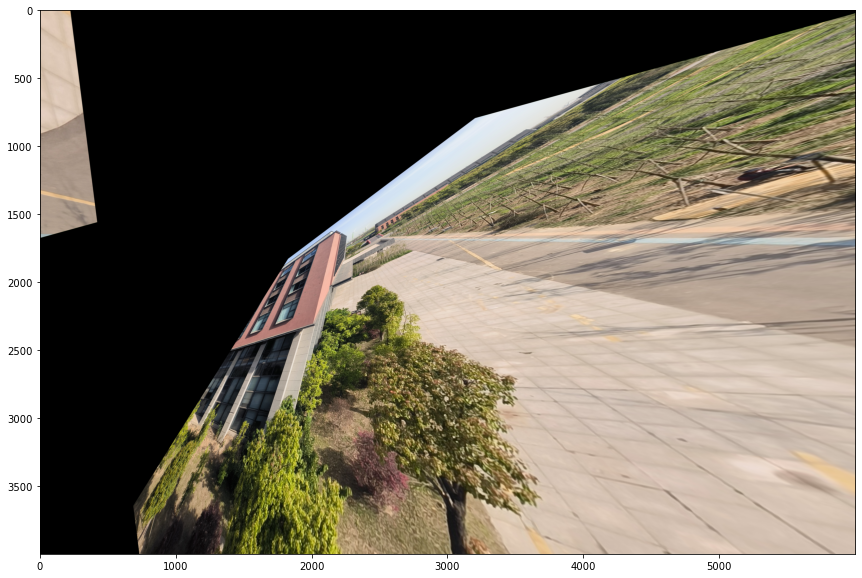

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(result)

In [7]:
from PIL import Image
img = Image.fromarray(result)
# img.show()
img.save('result.png')